In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
# hyperparameters
batch_size = 64 
block_size = 256 # spatial extent of the model for its context
max_iters = 500 # number of training iterations
eval_interval = 100 # frequency of printing training stats
learning_rate = 3e-4
device = torch.device('mps')
eval_iters = 200 # number of iterations to evaluate the model
n_embd = 384
n_layers = 6
dropout = 0.2
n_head = 6
data_filepath = 'commedia.txt'
train_val_split = 0.95

In [3]:

# Load data
with open(data_filepath, 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)} # string to int
itos = {i: ch for i, ch in enumerate(chars)} # int to string
def encode(s): return [stoi[ch] for ch in s]
def decode(l): return ''.join([itos[i] for i in l])

# Split in to train anv validation
data = torch.tensor(encode(text), dtype=torch.long)
n = int(train_val_split * len(data))
train_data = data[:n]
val_data = data[n:]
print(f' - Length of train data: {len(train_data)}')
print(f' - Length of val data: {len(val_data)}')

def get_batch(split, batch_size, block_size):
    """
    Get a batch of data for training or validation.

    Parameters:
    split (str): The split to get the data from. Can be 'train' or 'val'.
    batch_size (int): The batch size.
    block_size (int): The sequence length.

    Returns:
    torch.Tensor, torch.Tensor: The input data (x) and target data (y) as tensors.
    """

    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i + block_size] for i in ix])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])
    return x, y



 - Length of train data: 170866
 - Length of val data: 8993


In [4]:

class Transformer(nn.Module): 
    ''' A transformer language model. Parameters are defined in the hyperparameters section and do not need to be passed in.
    The class has two methods: forward and generate. Forward is used for training and generate is used for sampling.
    In the forward method, the input is a batch of sequences of tokens, and optionally a batch of target sequences of tokens.'''
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_layers) for _ in range(n_layers)]
        )
        self.final_ln = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        ''' idx is a batch of sequences of tokens. targets is a batch of target sequences of tokens. If targets is None, then the loss is not calculated.'''
        B, T = idx.shape
        # idx and targets are both (B,T) tensors. where B is batch size and T is the number of tokens in each sequence (block_size*batch_size)

        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.final_ln(x) # (B,T,C)
        logits = self.lm_head(x)  # (B,T,V)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        ''' idx is a batch of sequences of tokens. max_new_tokens is the maximum number of tokens to generate.'''
        for _ in range(max_new_tokens):
            # crop idx
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx


class Head(nn.Module):
    '''a single self attention head'''

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        wei = q @ k.transpose(-2, -1) * (C ** -0.5)  # (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        wei = self.dropout(wei)
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B,T,C)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        # Q. what is proj an abbreviation for? A. projection Q. What is meant by projection? A. I think it means that the output is the same size as the input.3
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)  # (B,T,C)
        out = self.proj(out)
        out = self.dropout(out)
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class LayerNorm(nn.Module):

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass

        xmean = x.mean(1, keepdim=True)  # batch mean
        xvar = x.var(1, keepdim=True)  # batch variance

        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [26]:
m = Transformer().to(device)
# Training loop
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
lossi = []  # loss history
print(f'Model is running on {device}')
print(f'Number of parameters: {format(sum(p.numel() for p in m.parameters()), ",")}')

Model is running on mps
Number of parameters: 10,785,084


In [20]:

# Training loop
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
lossi = []  # loss history
start_time = time.time()

for steps in range(max_iters):
    xb, yb = get_batch('train', batch_size, block_size)
    xb, yb = xb.to(device), yb.to(device)
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossi.append(loss.log10().item())

    if steps % eval_interval == 0 or steps == max_iters - 1:
        current_time = time.time() - start_time
        formatted_time = str(datetime.timedelta(seconds=current_time))
        print(f'step: {steps}, loss: {loss.item()}, time taken: {formatted_time}')

        # Estimate remaining time
        steps_remaining = max_iters - steps
        time_per_step = current_time / (steps + 1)  # Avoid division by zero
        remaining_time = datetime.timedelta(
            seconds=steps_remaining * time_per_step)
        print(f'estimated time remaining: {remaining_time}')

# Print the total training time
total_time = time.time() - start_time
formatted_total_time = str(datetime.timedelta(seconds=total_time))
print(f'Total training time: {formatted_total_time}')

step: 0, loss: 1.653496265411377, time taken: 0:00:03.714087
estimated time remaining: 0:30:57.043386
step: 100, loss: 1.6132299900054932, time taken: 0:04:19.011945
estimated time remaining: 0:17:05.789880
step: 200, loss: 1.5783698558807373, time taken: 0:07:52.135740
estimated time remaining: 0:11:44.680209
step: 300, loss: 1.5384883880615234, time taken: 0:10:12.260177
estimated time remaining: 0:06:46.817393
step: 400, loss: 1.4979515075683594, time taken: 0:12:24.665092
estimated time remaining: 0:03:05.702018
step: 499, loss: 1.4569706916809082, time taken: 0:14:36.043858
estimated time remaining: 0:00:01.752088
Total training time: 0:14:36.044546


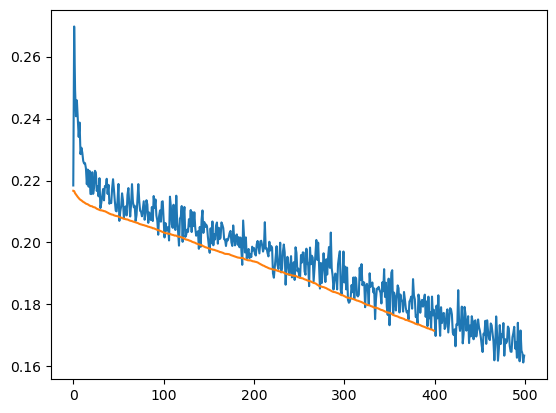

In [21]:
# Plot loss history

plt.plot(lossi)
lossi_means = [sum(lossi[i:i+100])/100 for i in range(len(lossi)-100)]
plt.plot(lossi_means)
plt.show()

In [22]:
# Evaluation loop over validation set

with torch.no_grad():
    total_loss = 0
    for steps in range(eval_iters):
        xb, yb = get_batch('val', batch_size, block_size)
        xb, yb = xb.to(device), yb.to(device)
        logits, loss = m(xb, yb)
        total_loss += loss.item()
    print(f'validation loss: {total_loss/eval_iters}')



validation loss: 1.609798847436905


In [23]:
# Generate from the model, printing the output as it goes
new_chars = 10000
idx = torch.zeros((1, 1), dtype=torch.long).to(device)

for _ in range(new_chars):
    output = m.generate(idx, 1)[0].tolist()
    decoded_output = decode(output)
    print(decoded_output[-1], end='')
    idx = torch.tensor([output], dtype=torch.long).to(device)


Magiman volt' avra in questa viena,
questo di pienza` li figliol ditillo:

perch' di disque, e sia pria che cudio
per un diver' la rima bolgavane,
si che maestro Auna si` taglie.

Perlo` del por ch'avea degno arrano che guida
nel sotto a Na la bastoldata e Ciocca
duca alcura, ed e` su` al maggio per che,

sanza la cela` som 'nfremmato afferorte.
Giochion che tredo
da lei; e` ten di quanci giu` e sua stagge".

Poi tu chi sopecci ch'i mestir cammi stali";
e io a lasposaipato divino il pianto.

"Se tu sapo, e che sia ciandi sedi,
e come non son fuor pron si discioco
se non conosculo alcura, in le gran sepo;

e l'alto mo`te, che vide il e diopetto
la di lorasbion di lui, ch'avesto,
quando sovr'bbia i procemedette retto.

Vedi membravan le man paero` si piedite,
fuore di di pedea la d'aesto miaggitia,
e che toste quanti mi scienno di Fio.

Nel carpo atte confesiziol tebra la mette,
le buerca di visiede; e un'orebbili,
ne' che s'i' discendeg.

Qua' io reivi, senno del dradette tremo;
che' se

KeyboardInterrupt: 